In [1]:
import h5py
import ROOT

import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

from tqdm import tqdm
from itertools import repeat

ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/')
ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/external/')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/classes/DelphesClasses.h"')
ROOT.gSystem.Load("/usr/local/Delphes-3.4.2/install/lib/libDelphes")

MAX_CONSTI = {
    'Tower': 200,
    'Track': 100,
    'Lepton': 2,
}
N_CORES = 64

Welcome to JupyROOT 6.20/08


In [2]:
def Mjets(*arg):
    # arg: list of jets
    # return: invariant mass of jets
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

# Basic checks

In [3]:
root_file = './ppZp/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')

i = 0
tree.GetEntry(i)
print(f'{"Index":<5} {"PID":<5} {"M1":<5} {"M2":<5} {"D1":<5} {"D2":<5} {"PT":<10} {"Eta":<10} {"Phi":<10} {"Mass":<10}')
for particle_id, particle in enumerate(tree.Particle):
    print(f'{particle_id:<5} {particle.PID:<5} {particle.M1:<5} {particle.M2:<5} {particle.D1:<5} {particle.D2:<5} {particle.PT:<10.5f} {particle.Eta:<10.5f} {particle.Phi:<10.5f} {particle.Mass:<10.5f}')


Index PID   M1    M2    D1    D2    PT         Eta        Phi        Mass      
0     -1    5     -1    3     4     0.00000    999.90002  0.00000    0.00000   
1     21    5     -1    15    15    38.62684   1.94690    -0.81923   0.00000   
2     1     6     -1    3     4     0.00000    -999.90002 0.00000    0.00000   
3     24    0     2     8     8     114.66643  0.01915    2.83476    79.90376  
4     -24   0     2     9     9     114.66643  1.66511    -0.30684   80.06834  
5     -1    10    -1    0     1     0.00000    999.90002  -0.78540   0.00000   
6     1     11    -1    2     2     0.00000    -999.90002 3.14159    0.00000   
7     21    11    -1    18    18    17.53825   -0.80202   -0.77965   0.00000   
8     24    3     -1    13    13    121.02259  0.02806    2.80545    79.90376  
9     -24   4     -1    14    14    88.65083   1.96826    -0.13233   80.06834  
10    -1    60    -1    5     5     0.00000    999.90002  -0.77305   0.00000   
11    1     61    -1    6     7     0.00

Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo of class Track read from file ./ppZp/Events/run_01/tag_1_delphes_events.root
   has the same version (=3) as the active class but a different checksum.
   You should update the version to ClassDef(Track,4).
   Do not try to write objects with the current class definition,
   the files will not be readable.

Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:
   float C; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:
   float Mass; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:
   float EtaOuter; //
Warning in <TStreamerInfo::CompareContent>: The following data member o

## Lepton number distribution

In [4]:
root_file = './ppZp/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
nevent = tree.GetEntries()

n_e, n_mu = [], []
for i in tqdm(range(nevent)):
    tree.GetEntry(i)
    n_e.append(tree.Electron_size)
    n_mu.append(tree.Muon_size)
    
    leading_leptons = []
    leptons = []
    for electron in tree.Electron:
        leptons.append([electron.PT, electron.Eta, electron.Phi, 0.000511])
    for muon in tree.Muon:
        leptons.append([muon.PT, muon.Eta, muon.Phi, 0.105])
    leptons = sorted(leptons, key=lambda x: x[0], reverse=True)
    if len(leptons) >= 2:
        leading_leptons.append(leptons[:2])

    m_ll = [Mjets(*leptons) for leptons in leading_leptons]
n_l = np.array(n_e) + np.array(n_mu)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:09<00:00, 1089.76it/s]


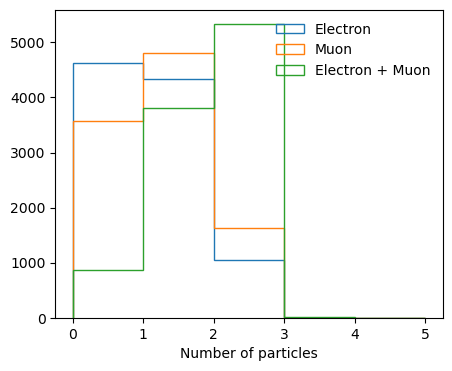

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(n_e, bins=5, range=(0, 5), histtype='step', label='Electron')
ax.hist(n_mu, bins=5, range=(0, 5), histtype='step', label='Muon')
ax.hist(n_l, bins=5, range=(0, 5), histtype='step', label='Electron + Muon')
ax.set_xlabel('Number of particles')
ax.legend(frameon=False)
# plt.savefig('../figures/n_particles.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## $m_{ll}$ distribution

In [6]:
def get_mll(tree):
    nevent = tree.GetEntries()
    leading_leptons = []
    for i in tqdm(range(nevent)):
        tree.GetEntry(i)
        leptons = []
        m_e, m_mu = 0.000511, 0.105
        for electron in tree.Electron:
            leptons.append([electron.PT, electron.Eta, electron.Phi, m_e])
        for muon in tree.Muon:
            leptons.append([muon.PT, muon.Eta, muon.Phi, m_mu])
        leptons = sorted(leptons, key=lambda x: x[0], reverse=True)
        if len(leptons) < 2:
            continue
        if len(leptons) >= 2:
            leading_leptons.append(leptons[:2])

    return [Mjets(*leptons) for leptons in leading_leptons]

In [7]:
root_file = './ppZp/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')

m_ll_ppZp = get_mll(tree)

root_file = './ppWpWm/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')

m_ll_ppWW = get_mll(tree)

root_file = './ppZZ/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')

m_ll_ppZZ = get_mll(tree)

100%|██████████| 100000/100000 [01:18<00:00, 1278.17it/s]
Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo for version 2 of class GenParticle read from the file ./ppZp/Events/run_02/tag_1_delphes_events.root
   has a different checksum than the previously loaded StreamerInfo.
   Reading objects of type GenParticle from the file ./ppZp/Events/run_02/tag_1_delphes_events.root 
   (and potentially other files) might not work correctly.
   Most likely the version number of the class was not properly
   updated [See ClassDef(GenParticle,2)].
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float T; //number
vs
   float CtgTheta; //number
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float X; //number
vs
   float D0; //number
Warni

In [8]:
len(m_ll_ppZp), len(m_ll_ppWW), len(m_ll_ppZZ)

(53879, 32678, 38773)

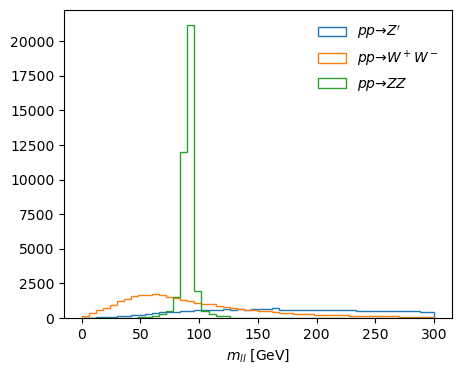

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(m_ll_ppZp, bins=50, range=(0, 300), histtype='step', label='$pp \\to Z\'$')
ax.hist(m_ll_ppWW, bins=50, range=(0, 300), histtype='step', label='$pp \\to W^+W^-$')
ax.hist(m_ll_ppZZ, bins=50, range=(0, 300), histtype='step', label='$pp \\to ZZ$')
ax.set_xlabel(r'$m_{ll}$ [GeV]')
ax.legend(frameon=False)
plt.savefig('../figures/mll_distribution.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Basic Information

In [10]:
def get_number_of_constituents(tree):

    # get number of constituents for each event
    # 1. number of photons >= 2

    n_consti = {'Tower': [], 
                'Track': []}

    for event_id, event in tqdm(enumerate(tree)):
        # if event_id == 10:
        #     break

        if event.Electron_size + event.Muon_size < 2:
            continue

        # extract all track and tower constituents
        constituents = [consti for consti in event.Tower if consti != 0]
        n_consti['Tower'].append(len(constituents))

        constituents = [consti for consti in event.Track if consti != 0]
        n_consti['Track'].append(len(constituents))
    return n_consti

In [11]:
root_file = './ppZp/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')

n_consti = get_number_of_constituents(tree)

9489it [00:08, 1120.51it/s]

10000it [00:09, 1062.98it/s]


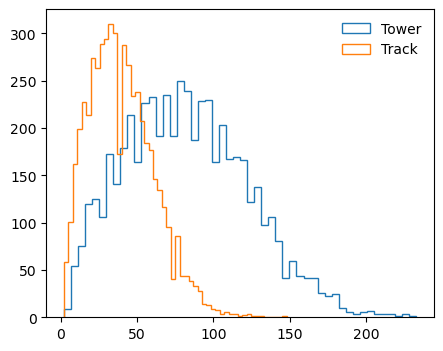

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(n_consti['Tower'], bins=50, histtype='step', label='Tower')
ax.hist(n_consti['Track'], bins=50, histtype='step', label='Track')
ax.legend(frameon=False)
plt.show()

In [13]:
root_file = './ppWpWm/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')

n_consti = get_number_of_constituents(tree)

10000it [00:08, 1145.08it/s]


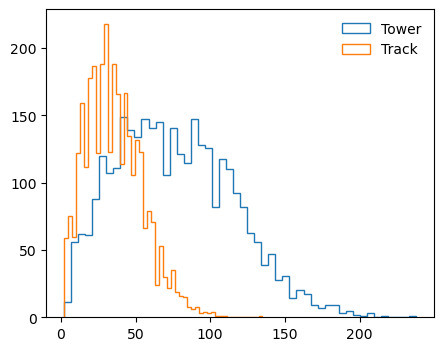

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(n_consti['Tower'], bins=50, histtype='step', label='Tower')
ax.hist(n_consti['Track'], bins=50, histtype='step', label='Track')
ax.legend(frameon=False)
plt.show()

In [15]:
root_file = './ppZZ/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')

n_consti = get_number_of_constituents(tree)

10000it [00:08, 1131.46it/s]


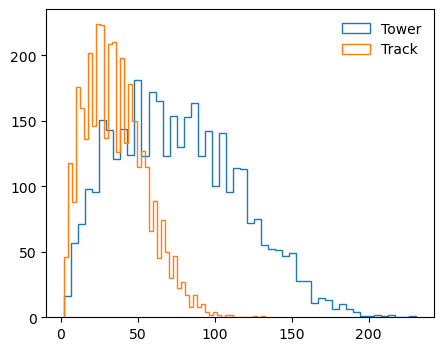

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(n_consti['Tower'], bins=50, histtype='step', label='Tower')
ax.hist(n_consti['Track'], bins=50, histtype='step', label='Track')
ax.legend(frameon=False)
plt.show()

# From .root to .h5

In [17]:
# HDF5
def create_dataset(f, nevent, MAX_CONSTI):

    f.create_dataset('Tower/mask', (nevent, MAX_CONSTI['Tower']), maxshape=(None, MAX_CONSTI['Tower']), dtype='|b1')
    f.create_dataset('Tower/pt', (nevent, MAX_CONSTI['Tower']), maxshape=(None, MAX_CONSTI['Tower']), dtype='<f4')
    f.create_dataset('Tower/eta', (nevent, MAX_CONSTI['Tower']), maxshape=(None, MAX_CONSTI['Tower']), dtype='<f4')
    f.create_dataset('Tower/phi', (nevent, MAX_CONSTI['Tower']), maxshape=(None, MAX_CONSTI['Tower']), dtype='<f4')

    f.create_dataset('Track/mask', (nevent, MAX_CONSTI['Track']), maxshape=(None, MAX_CONSTI['Track']), dtype='|b1')
    f.create_dataset('Track/pt', (nevent, MAX_CONSTI['Track']), maxshape=(None, MAX_CONSTI['Track']), dtype='<f4')
    f.create_dataset('Track/eta', (nevent, MAX_CONSTI['Track']), maxshape=(None, MAX_CONSTI['Track']), dtype='<f4')
    f.create_dataset('Track/phi', (nevent, MAX_CONSTI['Track']), maxshape=(None, MAX_CONSTI['Track']), dtype='<f4')

    f.create_dataset('Lepton/pt', (nevent, MAX_CONSTI['Lepton']), maxshape=(None, MAX_CONSTI['Lepton']), dtype='<f4')
    f.create_dataset('Lepton/eta', (nevent, MAX_CONSTI['Lepton']), maxshape=(None, MAX_CONSTI['Lepton']), dtype='<f4')
    f.create_dataset('Lepton/phi', (nevent, MAX_CONSTI['Lepton']), maxshape=(None, MAX_CONSTI['Lepton']), dtype='<f4')
    f.create_dataset('Lepton/mass', (nevent, MAX_CONSTI['Lepton']), maxshape=(None, MAX_CONSTI['Lepton']), dtype='<f4')

    f.create_dataset('Event/mll', (nevent,), maxshape=(None,), dtype='<f4')
    f.create_dataset('Event/type', (nevent,), maxshape=(None,), dtype='<i8')


def write_dataset(file, data: list):
    nevent = len(data)
    
    for key in data[0].keys():
        # Resize
        shape = list(file[key].shape)
        shape[0] = nevent
        file[key].resize(shape)
        # Write
        value = np.array([data_dict[key] for data_dict in data])
        file[key][:] = value


def get_dataset_keys(f):
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys

In [18]:
def get_pt_eta_phi(constituents):
    pts = np.array([consti.PT if hasattr(consti, 'PT') else consti.ET for consti in constituents])
    etas = np.array([consti.Eta for consti in constituents])
    phis = np.array([consti.Phi for consti in constituents])
    return pts, etas, phis


def select_event(root_path, sample_type, start, end):

    f = ROOT.TFile(root_path)
    tree = f.Get("Delphes")

    data_list = []
    for i in tqdm(range(start, end)):
        tree.GetEntry(i)

        if tree.Electron_size + tree.Muon_size < 2:
            continue

        # get invariant mass of leading two leptons
        leading_leptons = []
        leptons = []
        m_e, m_mu = 0.000511, 0.105
        for electron in tree.Electron:
            leptons.append([electron.PT, electron.Eta, electron.Phi, m_e])
        for muon in tree.Muon:
            leptons.append([muon.PT, muon.Eta, muon.Phi, m_mu])
        leptons = sorted(leptons, key=lambda x: x[0], reverse=True)
        # if len(leptons) < 2:
        #     continue
        if len(leptons) >= 2:
            leading_leptons.append(leptons[:2])
        mll = Mjets(*leptons)

        # get tower constituents
        constituents = [consti for consti in tree.Tower if consti != 0]
        n_consti_1 = len(constituents)
        PT3, Eta3, Phi3 = get_pt_eta_phi(constituents)

        # get track constituents
        constituents = [consti for consti in tree.Track if consti != 0]
        n_consti_2 = len(constituents)
        PT4, Eta4, Phi4 = get_pt_eta_phi(constituents)

        if n_consti_1 < 5 or n_consti_2 < 5:
            continue

        # 準備寫入資料
        data_dict = {
 
            'Tower/mask': np.arange(MAX_CONSTI['Tower']) < n_consti_1,
            'Tower/pt': PT3[:MAX_CONSTI['Tower']] if n_consti_1 > MAX_CONSTI['Tower'] else np.pad(PT3, (0, MAX_CONSTI['Tower']-n_consti_1)),
            'Tower/eta': Eta3[:MAX_CONSTI['Tower']] if n_consti_1 > MAX_CONSTI['Tower'] else np.pad(Eta3, (0, MAX_CONSTI['Tower']-n_consti_1)),
            'Tower/phi': Phi3[:MAX_CONSTI['Tower']] if n_consti_1 > MAX_CONSTI['Tower'] else np.pad(Phi3, (0, MAX_CONSTI['Tower']-n_consti_1)),

            'Track/mask': np.arange(MAX_CONSTI['Track']) < n_consti_2,
            'Track/pt': PT4[:MAX_CONSTI['Track']] if n_consti_2 > MAX_CONSTI['Track'] else np.pad(PT4, (0, MAX_CONSTI['Track']-n_consti_2)),
            'Track/eta': Eta4[:MAX_CONSTI['Track']] if n_consti_2 > MAX_CONSTI['Track'] else np.pad(Eta4, (0, MAX_CONSTI['Track']-n_consti_2)),
            'Track/phi': Phi4[:MAX_CONSTI['Track']] if n_consti_2 > MAX_CONSTI['Track'] else np.pad(Phi4, (0, MAX_CONSTI['Track']-n_consti_2)),

            'Lepton/pt': np.array([leptons[i][0] for i in range(2)]),
            'Lepton/eta': np.array([leptons[i][1] for i in range(2)]),
            'Lepton/phi': np.array([leptons[i][2] for i in range(2)]),
            'Lepton/mass': np.array([leptons[i][3] for i in range(2)]),

            'Event/mll': mll,
            'Event/type': sample_type,
        }
        data_list.append(data_dict)

    return data_list


def from_root_to_h5(root_path, output_path, sample_type):
    # Select events and save the jets information to h5 file

    # Get number of events
    f = ROOT.TFile(root_path)
    nevent = f.Get("Delphes").GetEntries()
    print(f'Number of events: {nevent}')

    # Multi-core processing
    print(f'Number of cores: {N_CORES}')
    start = [nevent // N_CORES * i for i in range(N_CORES)]
    end = [nevent // N_CORES * (i+1) for i in range(N_CORES)]
    end[-1] = nevent

    with mp.Pool(processes=N_CORES) as pool:
        results = pool.starmap(select_event, zip(repeat(root_path), repeat(sample_type), start, end))
    data_list = [data_dict for result_list in results for data_dict in result_list]

    # write to h5 file
    with h5py.File(output_path, 'w') as f_out:
        create_dataset(f_out, nevent, MAX_CONSTI)
        write_dataset(f_out, data_list)

In [19]:
sample_types = {
    'ppZp': 0,
    'ppWW': 1,
    'ppZZ': 2,
}


In [20]:
root_file = './ppZp/Events/run_03/tag_1_delphes_events.root'
output_path = './data/ppZp-03.h5'
sample_type = sample_types['ppZp']

from_root_to_h5(root_file, output_path, sample_type)

Number of events: 1000000
Number of cores: 64


 54%|█████▎    | 8385/15625 [00:40<00:08, 814.99it/s]]

100%|██████████| 15625/15625 [01:00<00:00, 259.38it/s]


In [21]:
root_file = './ppWpWm/Events/run_03/tag_1_delphes_events.root'
output_path = './data/ppWW-03.h5'
sample_type = sample_types['ppWW']

from_root_to_h5(root_file, output_path, sample_type)

Number of events: 1000000
Number of cores: 64


100%|██████████| 15625/15625 [00:33<00:00, 467.63it/s]


In [22]:
root_file = './ppZZ/Events/run_03/tag_1_delphes_events.root'
output_path = './data/ppZZ-03.h5'
sample_type = sample_types['ppZZ']

from_root_to_h5(root_file, output_path, sample_type)

Number of events: 1000000
Number of cores: 64


100%|██████████| 15625/15625 [01:13<00:00, 212.09it/s]
